In [3]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFile

# Dataset paths
base_dir = "dataset"

In [4]:
# Parameters
img_size = (224, 224)
batch_size = 32

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,  # Split dataset into 80% training and 20% validation
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [5]:
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)
ImageFile.LOAD_TRUNCATED_IMAGES = True

Found 1209 images belonging to 4 classes.
Found 300 images belonging to 4 classes.


In [6]:
# Get class weights to address class imbalance
classes = list(train_generator.class_indices.keys())
y_train = train_generator.classes
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

print(f"Class Weights: {class_weights}")

Class Weights: {0: np.float64(3.053030303030303), 1: np.float64(0.6964285714285714), 2: np.float64(1.2489669421487604), 3: np.float64(0.6964285714285714)}


In [7]:
# Build the model (using Transfer Learning)
base_model = tf.keras.applications.DenseNet121(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # Freeze the base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(len(classes), activation="softmax")
])

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)    

In [9]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights
)

C:\Users\Imran\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
12/38 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.2715 - loss: 1.8821

C:\Users\Imran\AppData\Roaming\Python\Python310\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


38/38 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.3660 - loss: 1.6141 - val_accuracy: 0.8400 - val_loss: 0.6213
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.6930 - loss: 0.8549 - val_accuracy: 0.9033 - val_loss: 0.3808
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.8070 - loss: 0.6773 - val_accuracy: 0.8933 - val_loss: 0.3509
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8570 - loss: 0.5774 - val_accuracy: 0.9167 - val_loss: 0.2929
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.8687 - loss: 0.4724 - val_accuracy: 0.9133 - val_loss: 0.2637
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9015 - loss: 0.3825 - val_accuracy: 0.9167 - val_loss: 0.2620
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9152 - loss: 0.3415 - val_accuracy: 0.9300 - val_loss: 0.2275
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9151 - loss: 0.3480 - val_accuracy: 0.9233 - val_loss: 0.2240
Ep

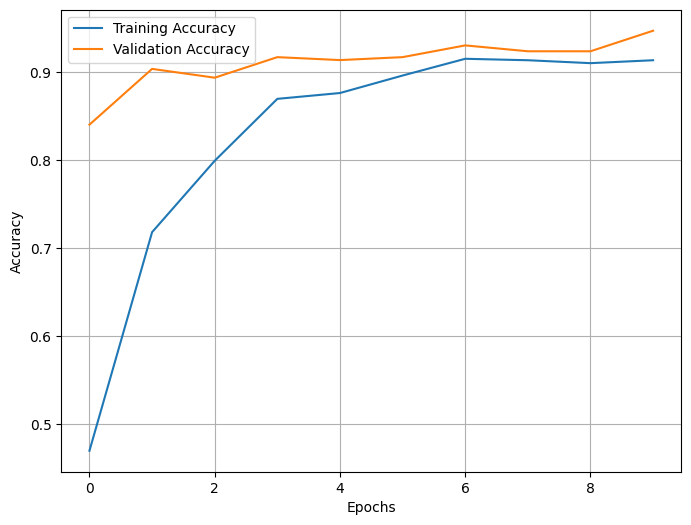

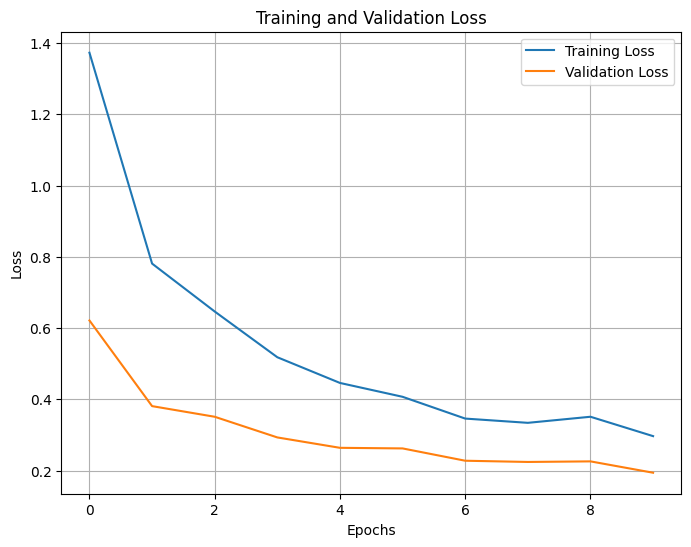

In [12]:
# Plot training history
plt.figure(figsize=(8, 6))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()


In [11]:
# Save the model
model.save("vehicle_classifier_densenet121.h5")
print("Model trained and saved successfully!")

Model trained and saved successfully!
